In [20]:
import numpy as np
from numpy import random
import torch as torch
from torch import nn
from torchvision import transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
torch.cuda.is_available()
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tensorflow as tf
from torchvision.datasets import ImageFolder

In [21]:
torch.cuda.get_device_name(0)
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [22]:
generate_res = (64,64)
PHOTO_PATH = "./data"

SEED_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 50     ## Increase this for better generated image 
img_width = 64
img_height = 64
channels = 3
n_critic = 5
learning_rate = 1e-4
beta1 = 0
beta2 = 0.9
latent_size = 128
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)



In [23]:

train_ds = ImageFolder(PHOTO_PATH, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)

In [24]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()
device

device(type='cuda')

In [27]:
training_data = DeviceDataLoader(train_dl, device)

In [28]:

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [42]:
discriminator = to_device(discriminator, device)

In [43]:


generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


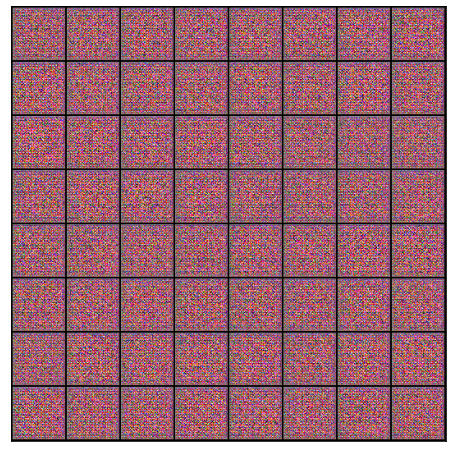

In [44]:
xb = torch.randn(BATCH_SIZE, SEED_SIZE, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [45]:
generator = to_device(generator, device)

In [46]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [47]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [48]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [49]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [50]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


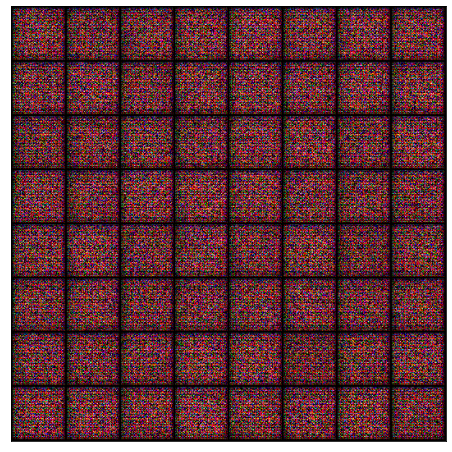

In [51]:
save_samples(0, fixed_latent)

In [52]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [53]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            real_images = to_device(real_images, device)
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [54]:
lr = 0.0002
epochs = 250

In [55]:
history = fit(epochs, lr)

  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [1/250], loss_g: 4.1194, loss_d: 0.5834, real_score: 0.7541, fake_score: 0.1985
Saving generated-images-0001.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [2/250], loss_g: 3.2167, loss_d: 0.5399, real_score: 0.6963, fake_score: 0.0949
Saving generated-images-0002.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [3/250], loss_g: 5.5098, loss_d: 0.7002, real_score: 0.9146, fake_score: 0.4006
Saving generated-images-0003.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [4/250], loss_g: 3.3278, loss_d: 0.6221, real_score: 0.6598, fake_score: 0.0884
Saving generated-images-0004.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [5/250], loss_g: 4.9076, loss_d: 1.7120, real_score: 0.2622, fake_score: 0.0031
Saving generated-images-0005.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [6/250], loss_g: 7.6186, loss_d: 0.8072, real_score: 0.9192, fake_score: 0.4830
Saving generated-images-0006.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [7/250], loss_g: 5.0389, loss_d: 0.5446, real_score: 0.6551, fake_score: 0.0167
Saving generated-images-0007.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [8/250], loss_g: 8.6291, loss_d: 0.5797, real_score: 0.9372, fake_score: 0.3637
Saving generated-images-0008.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [9/250], loss_g: 9.1383, loss_d: 0.8349, real_score: 0.9818, fake_score: 0.4859
Saving generated-images-0009.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [10/250], loss_g: 3.6645, loss_d: 0.4571, real_score: 0.7826, fake_score: 0.1124
Saving generated-images-0010.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [11/250], loss_g: 6.4864, loss_d: 0.3888, real_score: 0.9126, fake_score: 0.2347
Saving generated-images-0011.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [12/250], loss_g: 5.2833, loss_d: 0.3538, real_score: 0.9020, fake_score: 0.1863
Saving generated-images-0012.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [13/250], loss_g: 3.0973, loss_d: 0.1412, real_score: 0.9126, fake_score: 0.0335
Saving generated-images-0013.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [14/250], loss_g: 5.1059, loss_d: 0.2814, real_score: 0.9029, fake_score: 0.1410
Saving generated-images-0014.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [15/250], loss_g: 4.6309, loss_d: 0.3393, real_score: 0.7912, fake_score: 0.0417
Saving generated-images-0015.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [16/250], loss_g: 4.9535, loss_d: 0.0770, real_score: 0.9638, fake_score: 0.0367
Saving generated-images-0016.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [17/250], loss_g: 4.4784, loss_d: 0.4406, real_score: 0.8072, fake_score: 0.1437
Saving generated-images-0017.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [18/250], loss_g: 4.5608, loss_d: 0.3211, real_score: 0.8538, fake_score: 0.1183
Saving generated-images-0018.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [19/250], loss_g: 3.9012, loss_d: 0.3627, real_score: 0.7680, fake_score: 0.0278
Saving generated-images-0019.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [20/250], loss_g: 5.7311, loss_d: 0.1142, real_score: 0.9196, fake_score: 0.0251
Saving generated-images-0020.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [21/250], loss_g: 5.7573, loss_d: 0.2207, real_score: 0.9129, fake_score: 0.1092
Saving generated-images-0021.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [22/250], loss_g: 4.6745, loss_d: 0.2874, real_score: 0.8657, fake_score: 0.1112
Saving generated-images-0022.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [23/250], loss_g: 3.8392, loss_d: 0.1263, real_score: 0.9841, fake_score: 0.0924
Saving generated-images-0023.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [24/250], loss_g: 4.8558, loss_d: 0.1626, real_score: 0.9101, fake_score: 0.0486
Saving generated-images-0024.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [25/250], loss_g: 7.5090, loss_d: 0.2166, real_score: 0.8303, fake_score: 0.0022
Saving generated-images-0025.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [26/250], loss_g: 6.8203, loss_d: 0.3974, real_score: 0.7683, fake_score: 0.0019
Saving generated-images-0026.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [27/250], loss_g: 3.4377, loss_d: 0.4675, real_score: 0.7090, fake_score: 0.0047
Saving generated-images-0027.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [28/250], loss_g: 6.1381, loss_d: 0.2539, real_score: 0.9571, fake_score: 0.1623
Saving generated-images-0028.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [29/250], loss_g: 5.4449, loss_d: 0.2426, real_score: 0.9493, fake_score: 0.1555
Saving generated-images-0029.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [30/250], loss_g: 5.0305, loss_d: 0.3881, real_score: 0.8964, fake_score: 0.2010
Saving generated-images-0030.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [31/250], loss_g: 4.4004, loss_d: 0.0615, real_score: 0.9769, fake_score: 0.0344
Saving generated-images-0031.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [32/250], loss_g: 3.9433, loss_d: 0.2110, real_score: 0.8646, fake_score: 0.0216
Saving generated-images-0032.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [33/250], loss_g: 3.5881, loss_d: 0.2130, real_score: 0.8653, fake_score: 0.0392
Saving generated-images-0033.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [34/250], loss_g: 4.1690, loss_d: 0.2427, real_score: 0.8859, fake_score: 0.0928
Saving generated-images-0034.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [35/250], loss_g: 4.7310, loss_d: 0.1577, real_score: 0.8914, fake_score: 0.0233
Saving generated-images-0035.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [36/250], loss_g: 4.6096, loss_d: 0.1029, real_score: 0.9486, fake_score: 0.0435
Saving generated-images-0036.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [37/250], loss_g: 6.6746, loss_d: 0.2408, real_score: 0.9701, fake_score: 0.1657
Saving generated-images-0037.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [38/250], loss_g: 5.0082, loss_d: 0.1597, real_score: 0.9730, fake_score: 0.1134
Saving generated-images-0038.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [39/250], loss_g: 4.0138, loss_d: 0.1234, real_score: 0.9357, fake_score: 0.0493
Saving generated-images-0039.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [40/250], loss_g: 4.3008, loss_d: 0.0892, real_score: 0.9697, fake_score: 0.0528
Saving generated-images-0040.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [41/250], loss_g: 3.8825, loss_d: 0.1447, real_score: 0.9304, fake_score: 0.0549
Saving generated-images-0041.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [42/250], loss_g: 6.4882, loss_d: 0.3339, real_score: 0.9748, fake_score: 0.2028
Saving generated-images-0042.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [43/250], loss_g: 5.0661, loss_d: 0.1445, real_score: 0.8972, fake_score: 0.0212
Saving generated-images-0043.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [44/250], loss_g: 3.9253, loss_d: 0.1382, real_score: 0.9432, fake_score: 0.0690
Saving generated-images-0044.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [45/250], loss_g: 4.9974, loss_d: 0.1065, real_score: 0.9702, fake_score: 0.0693
Saving generated-images-0045.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [46/250], loss_g: 3.3054, loss_d: 0.3442, real_score: 0.7719, fake_score: 0.0075
Saving generated-images-0046.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [47/250], loss_g: 4.6250, loss_d: 0.1229, real_score: 0.9527, fake_score: 0.0468
Saving generated-images-0047.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [48/250], loss_g: 5.4625, loss_d: 0.0778, real_score: 0.9836, fake_score: 0.0543
Saving generated-images-0048.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [49/250], loss_g: 4.2256, loss_d: 0.1986, real_score: 0.8554, fake_score: 0.0127
Saving generated-images-0049.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [50/250], loss_g: 5.0976, loss_d: 0.2233, real_score: 0.9342, fake_score: 0.1209
Saving generated-images-0050.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [51/250], loss_g: 7.5135, loss_d: 0.5380, real_score: 0.9845, fake_score: 0.3330
Saving generated-images-0051.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [52/250], loss_g: 3.4582, loss_d: 0.4298, real_score: 0.6956, fake_score: 0.0011
Saving generated-images-0052.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [53/250], loss_g: 3.9450, loss_d: 0.1126, real_score: 0.9289, fake_score: 0.0347
Saving generated-images-0053.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [54/250], loss_g: 5.9010, loss_d: 0.2125, real_score: 0.9869, fake_score: 0.1570
Saving generated-images-0054.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [55/250], loss_g: 5.6005, loss_d: 0.3247, real_score: 0.9455, fake_score: 0.1685
Saving generated-images-0055.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [56/250], loss_g: 3.8428, loss_d: 0.0896, real_score: 0.9563, fake_score: 0.0395
Saving generated-images-0056.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [57/250], loss_g: 5.7954, loss_d: 0.0988, real_score: 0.9691, fake_score: 0.0592
Saving generated-images-0057.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [58/250], loss_g: 4.2328, loss_d: 0.1338, real_score: 0.9389, fake_score: 0.0607
Saving generated-images-0058.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [59/250], loss_g: 4.4492, loss_d: 0.1438, real_score: 0.9134, fake_score: 0.0342
Saving generated-images-0059.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [60/250], loss_g: 4.3138, loss_d: 0.2625, real_score: 0.8281, fake_score: 0.0181
Saving generated-images-0060.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [61/250], loss_g: 4.8150, loss_d: 0.1456, real_score: 0.9631, fake_score: 0.0916
Saving generated-images-0061.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [62/250], loss_g: 3.4063, loss_d: 0.1361, real_score: 0.9383, fake_score: 0.0607
Saving generated-images-0062.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [63/250], loss_g: 4.3813, loss_d: 0.2464, real_score: 0.9311, fake_score: 0.1378
Saving generated-images-0063.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [64/250], loss_g: 3.8922, loss_d: 0.1305, real_score: 0.9056, fake_score: 0.0259
Saving generated-images-0064.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [65/250], loss_g: 2.0215, loss_d: 0.1948, real_score: 0.8685, fake_score: 0.0323
Saving generated-images-0065.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [66/250], loss_g: 4.7442, loss_d: 0.0817, real_score: 0.9594, fake_score: 0.0353
Saving generated-images-0066.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [67/250], loss_g: 3.1597, loss_d: 0.1414, real_score: 0.9247, fake_score: 0.0536
Saving generated-images-0067.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [68/250], loss_g: 3.6979, loss_d: 0.2017, real_score: 0.8721, fake_score: 0.0504
Saving generated-images-0068.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [69/250], loss_g: 6.4046, loss_d: 0.1687, real_score: 0.9900, fake_score: 0.1345
Saving generated-images-0069.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [70/250], loss_g: 4.0670, loss_d: 0.0771, real_score: 0.9519, fake_score: 0.0226
Saving generated-images-0070.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [71/250], loss_g: 3.9800, loss_d: 0.1126, real_score: 0.9606, fake_score: 0.0631
Saving generated-images-0071.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [72/250], loss_g: 6.1937, loss_d: 0.0540, real_score: 0.9686, fake_score: 0.0193
Saving generated-images-0072.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [73/250], loss_g: 4.9877, loss_d: 0.4021, real_score: 0.9551, fake_score: 0.2351
Saving generated-images-0073.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [74/250], loss_g: 3.8851, loss_d: 0.1049, real_score: 0.9145, fake_score: 0.0104
Saving generated-images-0074.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [75/250], loss_g: 4.8083, loss_d: 0.0936, real_score: 0.9897, fake_score: 0.0752
Saving generated-images-0075.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [76/250], loss_g: 3.1205, loss_d: 0.1872, real_score: 0.8849, fake_score: 0.0510
Saving generated-images-0076.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [77/250], loss_g: 3.2965, loss_d: 0.1915, real_score: 0.8816, fake_score: 0.0379
Saving generated-images-0077.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [78/250], loss_g: 1.2539, loss_d: 1.3832, real_score: 0.3864, fake_score: 0.0002
Saving generated-images-0078.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [79/250], loss_g: 4.5708, loss_d: 0.1074, real_score: 0.9531, fake_score: 0.0506
Saving generated-images-0079.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [80/250], loss_g: 3.9931, loss_d: 0.0790, real_score: 0.9568, fake_score: 0.0292
Saving generated-images-0080.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [81/250], loss_g: 4.6100, loss_d: 0.2293, real_score: 0.9676, fake_score: 0.1386
Saving generated-images-0081.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [82/250], loss_g: 4.4184, loss_d: 0.0726, real_score: 0.9691, fake_score: 0.0367
Saving generated-images-0082.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [83/250], loss_g: 4.4624, loss_d: 0.0982, real_score: 0.9598, fake_score: 0.0486
Saving generated-images-0083.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [84/250], loss_g: 5.8078, loss_d: 0.1949, real_score: 0.9510, fake_score: 0.1182
Saving generated-images-0084.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [85/250], loss_g: 5.1242, loss_d: 0.0724, real_score: 0.9671, fake_score: 0.0364
Saving generated-images-0085.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [86/250], loss_g: 4.4712, loss_d: 0.0658, real_score: 0.9459, fake_score: 0.0081
Saving generated-images-0086.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [87/250], loss_g: 4.0924, loss_d: 0.1228, real_score: 0.9087, fake_score: 0.0176
Saving generated-images-0087.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [88/250], loss_g: 5.3901, loss_d: 0.0799, real_score: 0.9840, fake_score: 0.0578
Saving generated-images-0088.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [89/250], loss_g: 2.9212, loss_d: 0.1263, real_score: 0.9044, fake_score: 0.0075
Saving generated-images-0089.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [90/250], loss_g: 5.8307, loss_d: 0.0452, real_score: 0.9794, fake_score: 0.0227
Saving generated-images-0090.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [91/250], loss_g: 1.9423, loss_d: 0.1400, real_score: 0.9014, fake_score: 0.0218
Saving generated-images-0091.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [92/250], loss_g: 5.6248, loss_d: 0.0494, real_score: 0.9805, fake_score: 0.0278
Saving generated-images-0092.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [93/250], loss_g: 4.0108, loss_d: 0.2166, real_score: 0.9245, fake_score: 0.1044
Saving generated-images-0093.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [94/250], loss_g: 5.0196, loss_d: 0.0593, real_score: 0.9624, fake_score: 0.0192
Saving generated-images-0094.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [95/250], loss_g: 4.6465, loss_d: 0.0565, real_score: 0.9713, fake_score: 0.0255
Saving generated-images-0095.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [96/250], loss_g: 5.5098, loss_d: 0.0488, real_score: 0.9744, fake_score: 0.0205
Saving generated-images-0096.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [97/250], loss_g: 5.3781, loss_d: 0.0403, real_score: 0.9754, fake_score: 0.0142
Saving generated-images-0097.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [98/250], loss_g: 3.2393, loss_d: 0.2806, real_score: 0.8378, fake_score: 0.0648
Saving generated-images-0098.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [99/250], loss_g: 8.9052, loss_d: 5.4056, real_score: 1.0000, fake_score: 0.9860
Saving generated-images-0099.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [100/250], loss_g: 5.6576, loss_d: 0.0485, real_score: 0.9684, fake_score: 0.0147
Saving generated-images-0100.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [101/250], loss_g: 3.8428, loss_d: 0.0747, real_score: 0.9455, fake_score: 0.0162
Saving generated-images-0101.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [102/250], loss_g: 3.8662, loss_d: 0.9797, real_score: 0.9317, fake_score: 0.5003
Saving generated-images-0102.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [103/250], loss_g: 5.0265, loss_d: 0.0984, real_score: 0.9710, fake_score: 0.0514
Saving generated-images-0103.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [104/250], loss_g: 5.5600, loss_d: 0.0369, real_score: 0.9894, fake_score: 0.0247
Saving generated-images-0104.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [105/250], loss_g: 0.8846, loss_d: 0.8060, real_score: 0.5642, fake_score: 0.0037
Saving generated-images-0105.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [106/250], loss_g: 5.3965, loss_d: 0.0775, real_score: 0.9717, fake_score: 0.0423
Saving generated-images-0106.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [107/250], loss_g: 5.3281, loss_d: 0.0697, real_score: 0.9572, fake_score: 0.0227
Saving generated-images-0107.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [108/250], loss_g: 3.3495, loss_d: 0.0874, real_score: 0.9347, fake_score: 0.0162
Saving generated-images-0108.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [109/250], loss_g: 4.7078, loss_d: 0.0365, real_score: 0.9751, fake_score: 0.0108
Saving generated-images-0109.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [110/250], loss_g: 6.0195, loss_d: 0.0365, real_score: 0.9929, fake_score: 0.0280
Saving generated-images-0110.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [111/250], loss_g: 4.9155, loss_d: 0.1019, real_score: 0.9772, fake_score: 0.0652
Saving generated-images-0111.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [112/250], loss_g: 5.2562, loss_d: 0.2586, real_score: 0.9834, fake_score: 0.1759
Saving generated-images-0112.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [113/250], loss_g: 5.2128, loss_d: 0.0647, real_score: 0.9914, fake_score: 0.0501
Saving generated-images-0113.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [114/250], loss_g: 5.6406, loss_d: 0.1802, real_score: 0.9825, fake_score: 0.1262
Saving generated-images-0114.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [115/250], loss_g: 4.9036, loss_d: 0.0501, real_score: 0.9676, fake_score: 0.0152
Saving generated-images-0115.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [116/250], loss_g: 5.0790, loss_d: 0.0394, real_score: 0.9892, fake_score: 0.0266
Saving generated-images-0116.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [117/250], loss_g: 6.7531, loss_d: 0.0920, real_score: 0.9922, fake_score: 0.0609
Saving generated-images-0117.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [118/250], loss_g: 3.9480, loss_d: 0.0551, real_score: 0.9610, fake_score: 0.0137
Saving generated-images-0118.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [119/250], loss_g: 4.9366, loss_d: 0.0411, real_score: 0.9764, fake_score: 0.0162
Saving generated-images-0119.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [120/250], loss_g: 6.0696, loss_d: 0.0262, real_score: 0.9826, fake_score: 0.0083
Saving generated-images-0120.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [121/250], loss_g: 5.7706, loss_d: 0.0218, real_score: 0.9930, fake_score: 0.0143
Saving generated-images-0121.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [122/250], loss_g: 4.8553, loss_d: 0.4581, real_score: 0.8499, fake_score: 0.1790
Saving generated-images-0122.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [123/250], loss_g: 4.2305, loss_d: 0.7324, real_score: 0.5679, fake_score: 0.0151
Saving generated-images-0123.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [124/250], loss_g: 6.6628, loss_d: 0.1697, real_score: 0.9705, fake_score: 0.1142
Saving generated-images-0124.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [125/250], loss_g: 5.2940, loss_d: 0.0428, real_score: 0.9766, fake_score: 0.0173
Saving generated-images-0125.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [126/250], loss_g: 5.6730, loss_d: 0.0278, real_score: 0.9859, fake_score: 0.0129
Saving generated-images-0126.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [127/250], loss_g: 5.6008, loss_d: 0.0335, real_score: 0.9864, fake_score: 0.0190
Saving generated-images-0127.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [128/250], loss_g: 5.0158, loss_d: 0.0432, real_score: 0.9669, fake_score: 0.0086
Saving generated-images-0128.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [129/250], loss_g: 4.7084, loss_d: 0.2261, real_score: 0.9195, fake_score: 0.1037
Saving generated-images-0129.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [130/250], loss_g: 6.2713, loss_d: 0.0218, real_score: 0.9902, fake_score: 0.0116
Saving generated-images-0130.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [131/250], loss_g: 4.7893, loss_d: 0.0307, real_score: 0.9838, fake_score: 0.0139
Saving generated-images-0131.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [132/250], loss_g: 5.8663, loss_d: 0.0491, real_score: 0.9818, fake_score: 0.0283
Saving generated-images-0132.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [133/250], loss_g: 2.8337, loss_d: 0.6252, real_score: 0.7665, fake_score: 0.2230
Saving generated-images-0133.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [134/250], loss_g: 4.9671, loss_d: 0.0339, real_score: 0.9745, fake_score: 0.0075
Saving generated-images-0134.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [135/250], loss_g: 4.7684, loss_d: 0.0420, real_score: 0.9723, fake_score: 0.0108
Saving generated-images-0135.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [136/250], loss_g: 5.3047, loss_d: 0.0285, real_score: 0.9869, fake_score: 0.0141
Saving generated-images-0136.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [137/250], loss_g: 8.4324, loss_d: 0.1306, real_score: 0.9008, fake_score: 0.0030
Saving generated-images-0137.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [138/250], loss_g: 5.3439, loss_d: 0.0393, real_score: 0.9846, fake_score: 0.0221
Saving generated-images-0138.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [139/250], loss_g: 6.0043, loss_d: 0.0129, real_score: 0.9961, fake_score: 0.0089
Saving generated-images-0139.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [140/250], loss_g: 5.8127, loss_d: 0.1995, real_score: 0.8562, fake_score: 0.0115
Saving generated-images-0140.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [141/250], loss_g: 5.7947, loss_d: 0.0465, real_score: 0.9857, fake_score: 0.0293
Saving generated-images-0141.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [142/250], loss_g: 5.2035, loss_d: 0.0515, real_score: 0.9636, fake_score: 0.0114
Saving generated-images-0142.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [143/250], loss_g: 6.2440, loss_d: 0.0316, real_score: 0.9934, fake_score: 0.0234
Saving generated-images-0143.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [144/250], loss_g: 6.1030, loss_d: 0.0192, real_score: 0.9906, fake_score: 0.0093
Saving generated-images-0144.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [145/250], loss_g: 6.3806, loss_d: 0.0231, real_score: 0.9992, fake_score: 0.0208
Saving generated-images-0145.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [146/250], loss_g: 3.4808, loss_d: 0.5255, real_score: 0.8752, fake_score: 0.2650
Saving generated-images-0146.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [147/250], loss_g: 6.8517, loss_d: 0.1055, real_score: 0.9963, fake_score: 0.0863
Saving generated-images-0147.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [148/250], loss_g: 5.5795, loss_d: 0.0378, real_score: 0.9848, fake_score: 0.0211
Saving generated-images-0148.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [149/250], loss_g: 5.2008, loss_d: 0.0229, real_score: 0.9888, fake_score: 0.0111
Saving generated-images-0149.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [150/250], loss_g: 6.4726, loss_d: 0.0239, real_score: 0.9862, fake_score: 0.0095
Saving generated-images-0150.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [151/250], loss_g: 3.3061, loss_d: 0.0592, real_score: 0.9477, fake_score: 0.0036
Saving generated-images-0151.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [152/250], loss_g: 5.7862, loss_d: 0.0737, real_score: 0.9764, fake_score: 0.0447
Saving generated-images-0152.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [153/250], loss_g: 5.7083, loss_d: 0.0283, real_score: 0.9923, fake_score: 0.0191
Saving generated-images-0153.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [154/250], loss_g: 6.0613, loss_d: 0.0231, real_score: 0.9956, fake_score: 0.0175
Saving generated-images-0154.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [155/250], loss_g: 5.8949, loss_d: 0.0193, real_score: 0.9949, fake_score: 0.0138
Saving generated-images-0155.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [156/250], loss_g: 7.0021, loss_d: 0.0189, real_score: 0.9862, fake_score: 0.0047
Saving generated-images-0156.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [157/250], loss_g: 6.1121, loss_d: 0.0198, real_score: 0.9835, fake_score: 0.0031
Saving generated-images-0157.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [158/250], loss_g: 6.3438, loss_d: 0.0137, real_score: 0.9936, fake_score: 0.0071
Saving generated-images-0158.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [159/250], loss_g: 6.6292, loss_d: 0.0106, real_score: 0.9979, fake_score: 0.0083
Saving generated-images-0159.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [160/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0160.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [161/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0161.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [162/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0162.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [163/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0163.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [164/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0164.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [165/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0165.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [166/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0166.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [167/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0167.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [168/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0168.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [169/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0169.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [170/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0170.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [171/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0171.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [172/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0172.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [173/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0173.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [174/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0174.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [175/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0175.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [176/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0176.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [177/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0177.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [178/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0178.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [179/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0179.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [180/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0180.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [181/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0181.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [182/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0182.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [183/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0183.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [184/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0184.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [185/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0185.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [186/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0186.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [187/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0187.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [188/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0188.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [189/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0189.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [190/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0190.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [191/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0191.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [192/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0192.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [193/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0193.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [194/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0194.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [195/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0195.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [196/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0196.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [197/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0197.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [198/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0198.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [199/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0199.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [200/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0200.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [201/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0201.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [202/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0202.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [203/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0203.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [204/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0204.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [205/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0205.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [206/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0206.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [207/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0207.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [208/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0208.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [209/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0209.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [210/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0210.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [211/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0211.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [212/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0212.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [213/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0213.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [214/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0214.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [215/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0215.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [216/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0216.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [217/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0217.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [218/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0218.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [219/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0219.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [220/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0220.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [221/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0221.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [222/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0222.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [223/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0223.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [224/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0224.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [225/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0225.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [226/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0226.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [227/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0227.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [228/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0228.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [229/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0229.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [230/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0230.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [231/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0231.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [232/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0232.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [233/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0233.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [234/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0234.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [235/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0235.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [236/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0236.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [237/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0237.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [238/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0238.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [239/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0239.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [240/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0240.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [241/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0241.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [242/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0242.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [243/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0243.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [244/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0244.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [245/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0245.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [246/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0246.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [247/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0247.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [248/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0248.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [249/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0249.png


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [250/250], loss_g: 0.0000, loss_d: 100.0000, real_score: 1.0000, fake_score: 1.0000
Saving generated-images-0250.png


In [59]:
losses_g, losses_d, real_scores, fake_scores = history

In [60]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

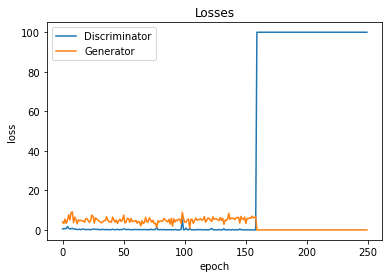

In [61]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

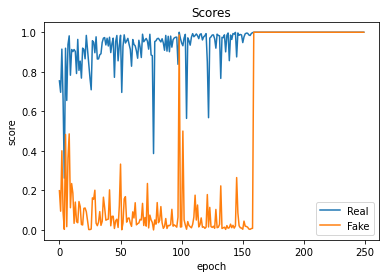

In [62]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');